In [1]:
import torch
import torch.nn.functional as F
import numpy as np
from torch import nn
from tqdm import tqdm
import torch.utils.data
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from sklearn.metrics import mean_squared_error
from time import time
import pandas as pd
from classes.policy_network import PolicyNetwork
from classes.diffusion_model import DiffusionModel
import time

In [2]:
DEVICE = 'mps'

In [3]:
def sample_batch(size):
    x, _ = make_swiss_roll(size)
    x = x[:, [2, 0]] / 10.0 * np.array([1, -1])
    return x[:, 0].reshape((1, size))

In [4]:
def reward_function(features, weights, bias=None):
    # Calculate the linear combination
    logits = torch.matmul(features, weights)

    # If bias is provided, add it to the logits
    if bias is not None:
        logits += bias

    # Apply the sigmoid function to get the probabilities
    probabilities = torch.sigmoid(logits)

    return probabilities

In [5]:
model_name = "01"
path_to_weights = (
    "/Users/hazimiasad/Documents/Work/megan/data/collection/Study1/sub-"
    + model_name
    + "/pattern/dc_weights.csv"
)
weights = torch.from_numpy(pd.read_csv(path_to_weights, header=None).values.T).to(
    DEVICE, dtype=torch.float32
)
state_size = len(weights)

In [6]:
def save_model(epoch, model, optimizer, loss, rewards, name, batch_size=32, max_grad_norm=1):
    torch.save({
        'epoch': epoch,
        'batch_size':batch_size,
        'max_grad_norm':max_grad_norm,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'rewards': rewards
    }, "/Users/hazimiasad/Documents/Work/megan/code/playground/RL-Diffusion/results/models/gradient/sub-"+model_name+"/"+name+".pth")

In [7]:
def train_rl(model, optimizer, reward_function, state_size, nb_epochs=150_000, batch_size=32, device='cpu', max_norm=.5):
    training_loss = []
    rewards = []
    for epoch in tqdm(range(nb_epochs), mininterval=60.0):
        batch_loss = 0
        batch_reward = 0
        for b in range(batch_size):
            x0 = torch.from_numpy(sample_batch(state_size)).float().to(device)
            t = 40
            mu_posterior, sigma_posterior, x = model.forward_process(x0, t)
            log_probs = []
            for t in range(41, 1, -1):
                # mu, sigma, x = model.reverse(x, t)
                action, log_prob, _, _ = model.select_action(x, t)
                log_probs.append(log_prob)
                x = x + action
        

            reward = reward_function(x, weights)
            batch_reward += reward
            reward = torch.tensor(reward, dtype=torch.float32).to(device)
            if torch.isnan(reward).any():
                print(f"NaN detected in reward at epoch {epoch}")
                break

            log_probs_stack_sum = torch.stack(log_probs).sum()
            loss = -reward * log_probs_stack_sum
            batch_loss += loss
        loss = batch_loss/batch_size
        reward = batch_reward/batch_size
        if torch.isnan(loss).any():
            print(f"NaN detected in loss at epoch {epoch}")
            break

        optimizer.zero_grad()
        loss.backward()

        # Check gradients
        for name, param in model.named_parameters():
            if param.grad is not None and torch.isnan(param.grad).any():
                print(f"NaN detected in gradients for {name} at epoch {epoch}")
                break

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_norm)
        optimizer.step()
        training_loss.append(loss.item())
        rewards.append(reward)
        name = str(time.time()) +'_epoch_'+str(epoch)
        save_model(epoch, model, optimizer, training_loss, rewards, name)
        # Check parameters
        for name, param in model.named_parameters():
            if torch.isnan(param).any():
                print(f"NaN detected in parameters for {name} at epoch {epoch}")
                break

    return training_loss, rewards

In [8]:
def train_reward(model, optimizer, reward_function, state_size, nb_epochs=150_000, batch_size=32, device='cpu', max_norm=0.5):
    """
    Trains the diffusion model to maximize a reward signal computed on the final output.
    This version does not use RL (e.g. REINFORCE) but instead backpropagates directly through
    a deterministic reverse diffusion process.

    Args:
        model: the diffusion model (which must implement forward_process() and reverse())
        optimizer: an optimizer for the model parameters
        reward_function: a callable that takes (x, weights) and returns a reward (assumed differentiable)
        state_size: size/shape information for sample_batch
        nb_epochs: number of training epochs
        batch_size: batch size per epoch
        device: device to use ('cpu' or 'cuda')
        max_norm: maximum gradient norm for clipping

    Returns:
        training_loss: list of loss values per epoch
        rewards: list of average rewards per epoch
    """
    training_loss = []
    rewards = []

    for epoch in tqdm(range(nb_epochs), mininterval=60.0):
        batch_loss = 0.0
        batch_reward = 0.0

        for b in range(batch_size):
            # Sample an initial state x0
            x0 = torch.from_numpy(sample_batch(state_size)).float().to(device)
            t = 40

            # Run the forward process (adding noise) to obtain a noisy sample x
            mu_posterior, sigma_posterior, x = model.forward_process(x0, t)

            # Instead of sampling actions via a policy (as in RL), run a deterministic reverse process
            # For each diffusion step, use the model's reverse function to gradually denoise x.
            for step in range(40, 0, -1):
                # Here we assume model.reverse(x, t) returns the denoised x at step t.
                # (If your model requires stochasticity you may need to adjust this accordingly.)
                x = model.reverse(x, step)
                # print(type(mean))
                # print(type(std))
                # print(type(nex))
                # x = mean

            # Compute the reward signal from the final sample x.
            # (Make sure that the variable `weights` is defined or passed as an argument as needed.)
            reward = reward_function(x, weights)
            # Convert reward to a tensor on the correct device.
            # reward_tensor = torch.tensor(reward_val, dtype=torch.float32, device=device)
            # if torch.isnan(reward_tensor).any():
            #     print(f"NaN detected in reward at epoch {epoch}")
            #     continue

            # We want to maximize the reward, so we minimize its negative.
            loss = -reward
            batch_loss += loss
            batch_reward += reward.item()

        # Average the losses and rewards over the batch.
        loss = batch_loss / batch_size
        avg_reward = batch_reward / batch_size
        # print('LOSS:', loss)
        if torch.isnan(loss).any():
            print(f"NaN detected in loss at epoch {epoch}")
            break

        optimizer.zero_grad()
        loss.backward()

        # Check gradients for NaNs.
        for name, param in model.named_parameters():
            if param.grad is not None and torch.isnan(param.grad).any():
                print(f"NaN detected in gradients for {name} at epoch {epoch}")
                break

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_norm)
        optimizer.step()

        training_loss.append(loss.item())
        rewards.append(avg_reward)
        checkpoint_name = f"{time.time()}_epoch_{epoch}"
        save_model(epoch, model, optimizer, training_loss, rewards, checkpoint_name)

        # Check parameters for NaNs.
        for name, param in model.named_parameters():
            if torch.isnan(param).any():
                print(f"NaN detected in parameters for {name} at epoch {epoch}")
                break

    return training_loss, rewards

In [9]:
policy_net = PolicyNetwork(state_size, state_size, device=DEVICE).to(DEVICE)
model = DiffusionModel(policy_net, device=DEVICE)
optimizer = torch.optim.Adam(policy_net.parameters(), lr=1e-4)

In [10]:
loss, rewards = train_reward(model, optimizer, reward_function, state_size,nb_epochs=300,  device=DEVICE, max_norm=1)

100%|██████████| 300/300 [12:02<00:00,  2.41s/it]


In [ ]:
# loss, rewards = train_rl(model, optimizer, reward_function, state_size,nb_epochs=300,  device=DEVICE, max_norm=1)

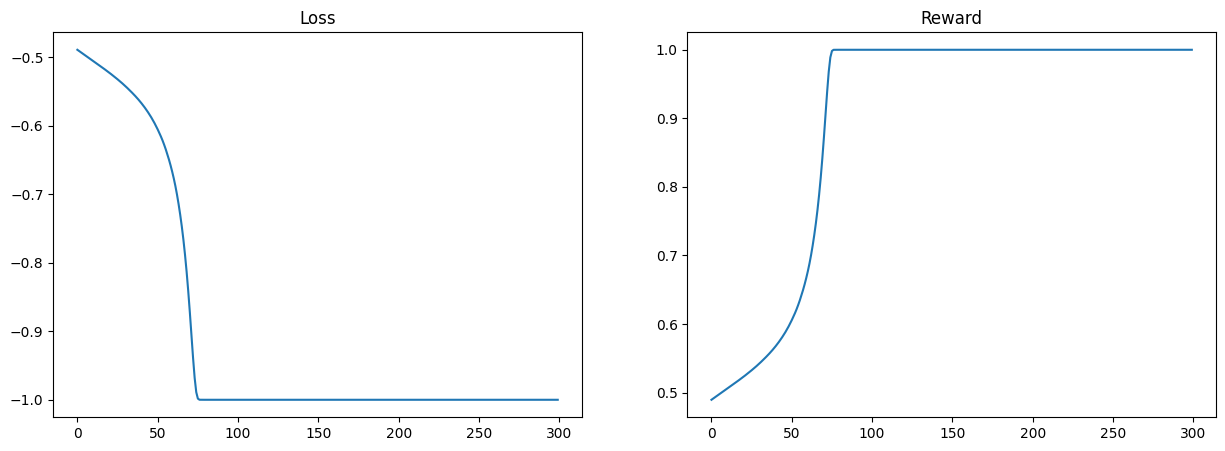

In [12]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.title('Loss')
plt.plot(loss)
plt.subplot(122)
plt.title('Reward')
# plt.plot([r.item() for r in rewards[:]])
plt.plot([r for r in rewards])
plt.savefig('../results/Imgs/sub-'+model_name+'/'+model_name+'_train.pdf')
plt.show()

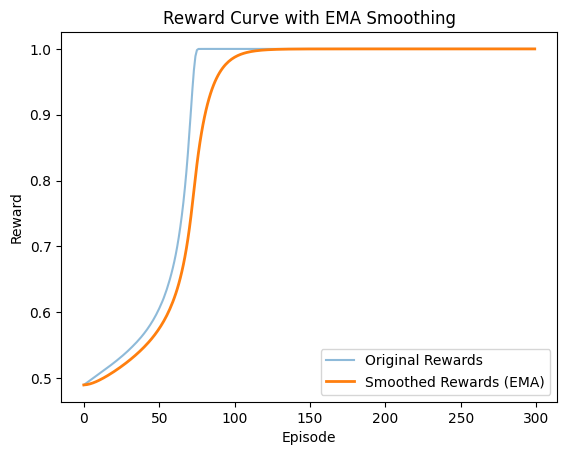

In [14]:
# rewards = [r.item() for r in rewards[:]]

def exponential_moving_average(data, alpha=0.1):
    ema = []
    for i, value in enumerate(data):
        if i == 0:
            ema.append(value)
        else:
            ema.append(alpha * value + (1 - alpha) * ema[-1])
    return ema

# Smooth the rewards with EMA
alpha = 0.1  # Smoothing factor
smoothed_rewards_ema = exponential_moving_average(rewards, alpha)

# Plot the original and smoothed rewards
plt.plot(rewards, label='Original Rewards', alpha=0.5)
plt.plot(smoothed_rewards_ema, label='Smoothed Rewards (EMA)', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward Curve with EMA Smoothing')
plt.legend()
plt.show()